In [1]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam,SGD
from sklearn.utils import shuffle
import pickle
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
seed = 124
InputPath = "data/"
X = pickle.load(open(InputPath+"X2_clean.pickle","rb"))
y = pickle.load(open(InputPath+"y2_clean.pickle","rb"))
X,y=shuffle(X,y, random_state=seed)
X = X/255.0
y = tf.keras.utils.to_categorical(y).astype(int)
print(X.shape)
print(y.shape)
print(np.amax(X))

print(np.amin(X))

(2174, 51, 51, 3)
(2174, 5)
1.0
0.0


In [3]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=seed)

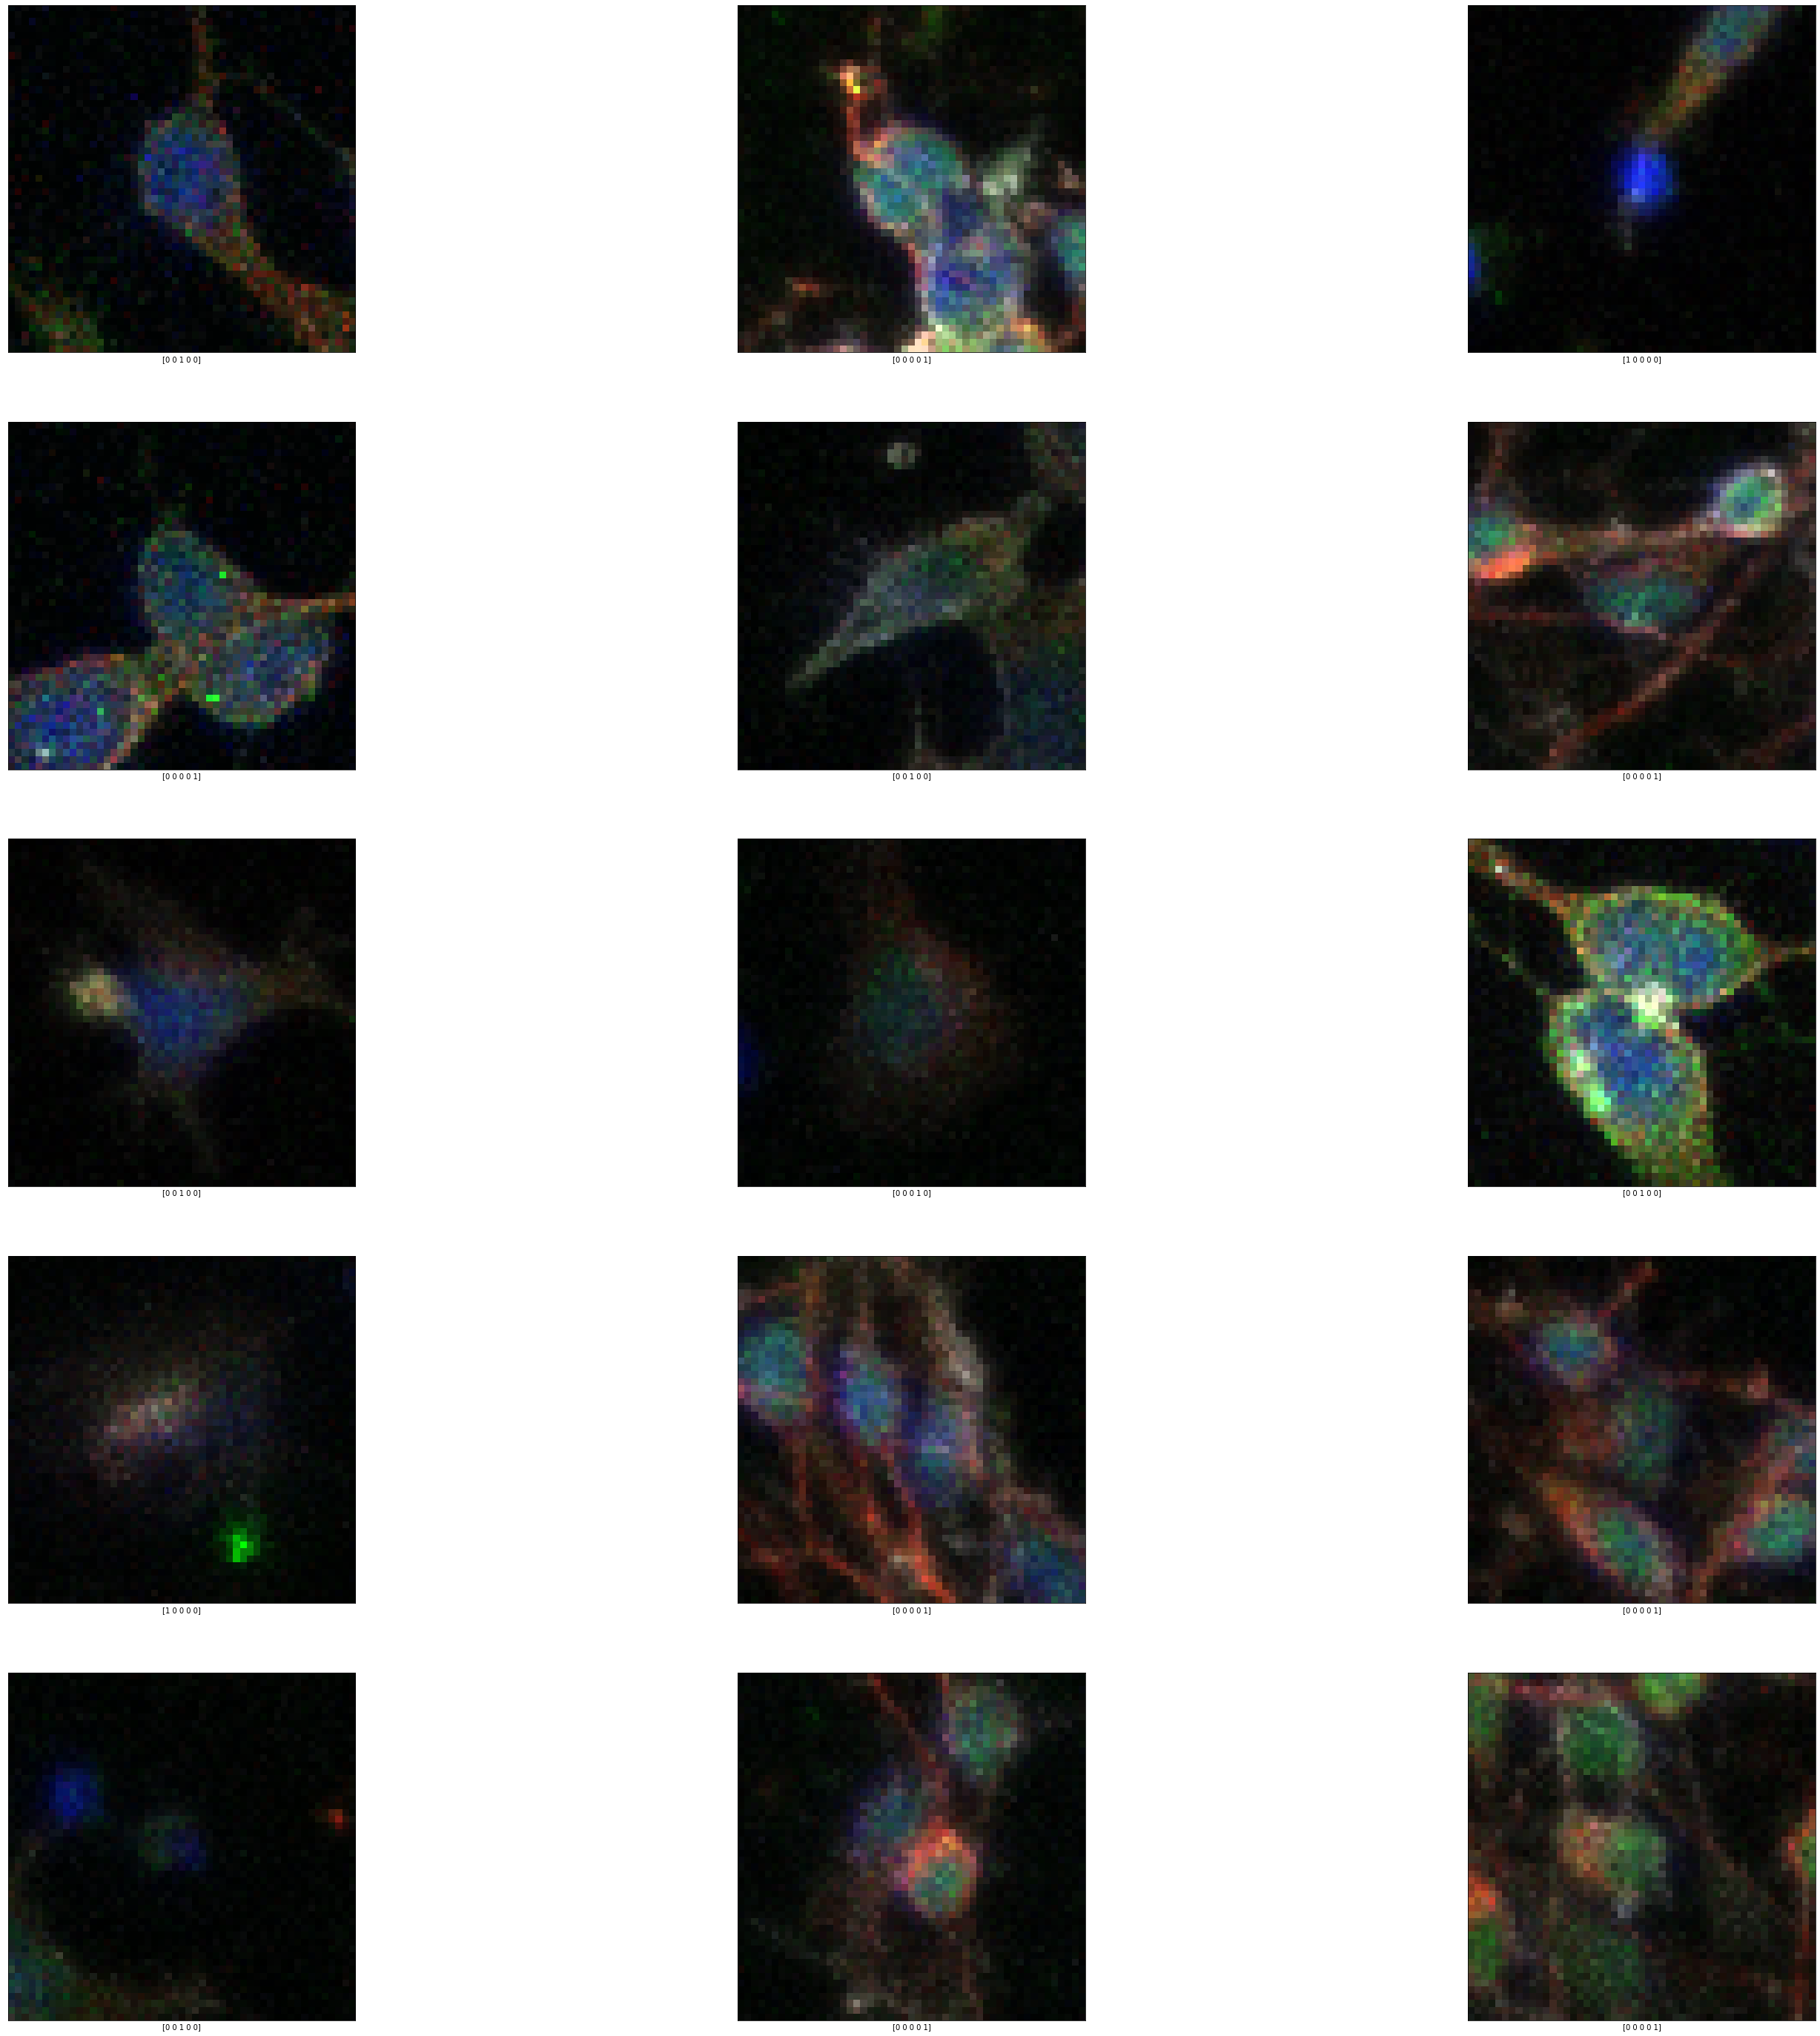

In [4]:
plt.figure(figsize=(50,50))
for i in range(15):
    plt.subplot(5,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_X[i], cmap=plt.cm.binary)
    plt.xlabel(str(train_y[i]))
plt.show()

In [5]:
# NAME = "Cnn64x2-{}-fix_X_withActivation".format(int(time.time()))
# from models import simple_cnn_model
# model = simple_cnn_model()
# model.compile(loss=tf.keras.losses.categorical_crossentropy,optimizer=tf.keras.optimizers.Adadelta(), metrics=['accuracy'])
# model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
# sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
# model.compile(optimizer=sgd, loss='categorical_crossentropy',metrics=['accuracy'])

In [6]:
# gpu_option = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
# sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [7]:
# weights = [301, 493, 531, 329, 628]
weights = [286, 459, 512, 317, 600]
total = sum(weights)
weights[:] = [x / total for x in weights]
print(weights)
classWeights = { i : weights[i] for i in range(0, len(weights) ) }
classWeights

[0.13155473781048757, 0.21113155473781048, 0.23551057957681693, 0.14581416743330267, 0.27598896044158233]


{0: 0.13155473781048757,
 1: 0.21113155473781048,
 2: 0.23551057957681693,
 3: 0.14581416743330267,
 4: 0.27598896044158233}

In [8]:
NAME = "VGG-updated_{}".format(int(time.time()))
tensorboard = tf.keras.callbacks.TensorBoard(log_dir='logs/{}'.format(NAME))

In [9]:
from models import VGG_16
model = VGG_16()
adam = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer=adam, loss=tf.keras.losses.categorical_crossentropy,metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 53, 53, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 51, 51, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 51, 51, 64)        256       
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 53, 53, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 51, 51, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 64)        0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 27, 27, 64)        0

In [10]:
# datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#         featurewise_center=False,  # set input mean to 0 over the dataset
#         samplewise_center=False,  # set each sample mean to 0
#         featurewise_std_normalization=False,  # divide inputs by std of the dataset
#         samplewise_std_normalization=False,  # divide each input by its std
#         zca_whitening=False,  # apply ZCA whitening
#         rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
#         width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
#         height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
#         horizontal_flip=True,  # randomly flip images
#         vertical_flip=False) 

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
                            rotation_range=360,
                             width_shift_range=0.05,
                             height_shift_range=0.05,
                             shear_range=0.10,
                             zoom_range=0.3,
                             horizontal_flip=True, 
                             vertical_flip=True,
                             brightness_range=[0.8,1.0],
                             rescale=1./255.
                            )

In [12]:
datagen.fit(train_X)

In [13]:
# it = datagen.flow(train_X, train_y, batch_size=1)
# plt.figure(figsize=(15,15))
# plt.tight_layout()
# for i in range(36):
#     plt.subplot(6,6,i+1)
#     plt.axis('off')
#     batch = it.next()
#     image = batch[0]
#     label = batch[1][0]
#     print(np.min(image), np.max(image), np.mean(image), np.std(image))
#     plt.imshow(image[0,:,:,0])
#     plt.text(10,30,label, color='green', size=20)
# plt.show()

In [14]:
import os
from datetime import datetime

# checkpoint_path = "models/"+NAME+"-{epoch:02d}-{val_acc:.2f}.hdf5"

checkpoint_path = "models/"+NAME+".hdf5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_acc', verbose=0, 
#                                 save_best_only=True, save_weights_only=False, mode='auto', period=1)
# checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_acc', verbose=0, save_best_only=False, mode='max')
# cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_acc', verbose=1,
#     save_best_only=True, save_weights_only=False,save_frequency=100)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = "logs/scalars/" + NAME

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
# import sys
# oldStdout = sys.stdout
# file = open('trainLog.txt', 'w')
# sys.stdout = file

history = model.fit_generator(datagen.flow(train_X, train_y, batch_size=32), epochs=500, 
                    validation_data=(test_X, test_y),class_weight=classWeights,callbacks=[cp_callback,tensorboard_callback])
# history = model.fit(x=train_X, y=train_y, batch_size=64, epochs=500, 
#                     validation_data=(test_X, test_y),class_weight=classWeights,callbacks=[cp_callback,tensorboard_callback])

Epoch 1/500
54/55 [============================>.] - ETA: 0s - loss: 0.3042 - accuracy: 0.2736
Epoch 00001: val_accuracy improved from -inf to 0.22989, saving model to models/VGG-updated_1581434078.hdf5
55/55 [==============================] - 9s 161ms/step - loss: 0.3036 - accuracy: 0.2749 - val_loss: 1.6029 - val_accuracy: 0.2299
Epoch 2/500
54/55 [============================>.] - ETA: 0s - loss: 0.2819 - accuracy: 0.3527
Epoch 00002: val_accuracy did not improve from 0.22989
55/55 [==============================] - 6s 118ms/step - loss: 0.2821 - accuracy: 0.3542 - val_loss: 1.5700 - val_accuracy: 0.2299
Epoch 3/500
54/55 [============================>.] - ETA: 0s - loss: 0.2763 - accuracy: 0.3773
Epoch 00003: val_accuracy improved from 0.22989 to 0.38621, saving model to models/VGG-updated_1581434078.hdf5
55/55 [==============================] - 8s 149ms/step - loss: 0.2758 - accuracy: 0.3767 - val_loss: 1.5161 - val_accuracy: 0.3862
Epoch 4/500
54/55 [============================>

54/55 [============================>.] - ETA: 0s - loss: 0.1774 - accuracy: 0.6620
Epoch 00028: val_accuracy did not improve from 0.63908
55/55 [==============================] - 6s 117ms/step - loss: 0.1783 - accuracy: 0.6601 - val_loss: 0.9839 - val_accuracy: 0.6092
Epoch 29/500
54/55 [============================>.] - ETA: 0s - loss: 0.1670 - accuracy: 0.6755
Epoch 00029: val_accuracy did not improve from 0.63908
55/55 [==============================] - 7s 120ms/step - loss: 0.1658 - accuracy: 0.6791 - val_loss: 1.0812 - val_accuracy: 0.5747
Epoch 30/500
54/55 [============================>.] - ETA: 0s - loss: 0.1654 - accuracy: 0.6840
Epoch 00030: val_accuracy did not improve from 0.63908
55/55 [==============================] - 7s 130ms/step - loss: 0.1655 - accuracy: 0.6832 - val_loss: 1.0213 - val_accuracy: 0.6161
Epoch 31/500
54/55 [============================>.] - ETA: 0s - loss: 0.1682 - accuracy: 0.6725
Epoch 00031: val_accuracy did not improve from 0.63908
55/55 [=========

Epoch 57/500
54/55 [============================>.] - ETA: 0s - loss: 0.1401 - accuracy: 0.7165
Epoch 00057: val_accuracy improved from 0.64368 to 0.66207, saving model to models/VGG-updated_1581434078.hdf5
55/55 [==============================] - 8s 144ms/step - loss: 0.1407 - accuracy: 0.7142 - val_loss: 0.8811 - val_accuracy: 0.6621
Epoch 58/500
54/55 [============================>.] - ETA: 0s - loss: 0.1437 - accuracy: 0.7129
Epoch 00058: val_accuracy did not improve from 0.66207
55/55 [==============================] - 6s 118ms/step - loss: 0.1431 - accuracy: 0.7136 - val_loss: 0.9278 - val_accuracy: 0.6161
Epoch 59/500
54/55 [============================>.] - ETA: 0s - loss: 0.1467 - accuracy: 0.7165
Epoch 00059: val_accuracy did not improve from 0.66207
55/55 [==============================] - 6s 112ms/step - loss: 0.1471 - accuracy: 0.7171 - val_loss: 1.1353 - val_accuracy: 0.5862
Epoch 60/500
54/55 [============================>.] - ETA: 0s - loss: 0.1546 - accuracy: 0.6960
Ep

Epoch 86/500
54/55 [============================>.] - ETA: 0s - loss: 0.1289 - accuracy: 0.7446
Epoch 00086: val_accuracy did not improve from 0.66207
55/55 [==============================] - 6s 116ms/step - loss: 0.1289 - accuracy: 0.7430 - val_loss: 1.1906 - val_accuracy: 0.5839
Epoch 87/500
54/55 [============================>.] - ETA: 0s - loss: 0.1270 - accuracy: 0.7422
Epoch 00087: val_accuracy did not improve from 0.66207
55/55 [==============================] - 6s 116ms/step - loss: 0.1279 - accuracy: 0.7401 - val_loss: 1.0958 - val_accuracy: 0.5770
Epoch 88/500
54/55 [============================>.] - ETA: 0s - loss: 0.1294 - accuracy: 0.7393
Epoch 00088: val_accuracy did not improve from 0.66207
55/55 [==============================] - 6s 110ms/step - loss: 0.1291 - accuracy: 0.7395 - val_loss: 0.9837 - val_accuracy: 0.6161
Epoch 89/500
54/55 [============================>.] - ETA: 0s - loss: 0.1278 - accuracy: 0.7405
Epoch 00089: val_accuracy did not improve from 0.66207
55/

Epoch 115/500
54/55 [============================>.] - ETA: 0s - loss: 0.1090 - accuracy: 0.7686
Epoch 00115: val_accuracy did not improve from 0.66207
55/55 [==============================] - 6s 116ms/step - loss: 0.1095 - accuracy: 0.7688 - val_loss: 1.1496 - val_accuracy: 0.6115
Epoch 116/500
54/55 [============================>.] - ETA: 0s - loss: 0.1116 - accuracy: 0.7786
Epoch 00116: val_accuracy did not improve from 0.66207
55/55 [==============================] - 6s 112ms/step - loss: 0.1124 - accuracy: 0.7769 - val_loss: 1.3064 - val_accuracy: 0.5931
Epoch 117/500
54/55 [============================>.] - ETA: 0s - loss: 0.1178 - accuracy: 0.7586
Epoch 00117: val_accuracy did not improve from 0.66207
55/55 [==============================] - 7s 119ms/step - loss: 0.1174 - accuracy: 0.7596 - val_loss: 1.0797 - val_accuracy: 0.6138
Epoch 118/500
54/55 [============================>.] - ETA: 0s - loss: 0.1149 - accuracy: 0.7569
Epoch 00118: val_accuracy did not improve from 0.66207

Epoch 144/500
54/55 [============================>.] - ETA: 0s - loss: 0.1053 - accuracy: 0.7815
Epoch 00144: val_accuracy did not improve from 0.66207
55/55 [==============================] - 7s 119ms/step - loss: 0.1049 - accuracy: 0.7815 - val_loss: 1.3007 - val_accuracy: 0.6161
Epoch 145/500
54/55 [============================>.] - ETA: 0s - loss: 0.1080 - accuracy: 0.7932
Epoch 00145: val_accuracy did not improve from 0.66207
55/55 [==============================] - 6s 116ms/step - loss: 0.1085 - accuracy: 0.7930 - val_loss: 1.2122 - val_accuracy: 0.6115
Epoch 146/500
54/55 [============================>.] - ETA: 0s - loss: 0.0993 - accuracy: 0.7879
Epoch 00146: val_accuracy did not improve from 0.66207
55/55 [==============================] - 6s 117ms/step - loss: 0.0990 - accuracy: 0.7890 - val_loss: 1.2430 - val_accuracy: 0.5977
Epoch 147/500
54/55 [============================>.] - ETA: 0s - loss: 0.0993 - accuracy: 0.7897
Epoch 00147: val_accuracy did not improve from 0.66207

In [ ]:
import sklearn
import numpy as np
import Plot
test_loss, test_acc = model.evaluate(test_X,  test_y, verbose=2)

Plot.plot_accuracy_curve(history)
y_pred = model.predict(test_X)
map_characters = {0:'Dead',1:'1',2:'2',3:'3',4:'Complex'}
print('\n', sklearn.metrics.classification_report(np.where(test_y > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
Y_pred_classes = np.argmax(y_pred,axis=1) 
Y_true = np.argmax(test_y,axis=1)
# plotKerasLearningCurve()
# plt.show()  
Plot.plot_learning_curve(history)
plt.show()
confusion_mtx = sklearn.metrics.confusion_matrix(Y_true, Y_pred_classes) 
Plot.plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values())) 
plt.show()


In [ ]:
# import os
# from datetime import datetime

# NAME = "VGG_withoutRegulation-{}".format(int(time.time()))


# # checkpoint_path = "models/"+NAME+"-{epoch:02d}-{val_acc:.2f}.hdf5"

# checkpoint_path = "models/"+NAME+".hdf5"
# checkpoint_dir = os.path.dirname(checkpoint_path)

# # cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_acc', verbose=0, 
# #                                 save_best_only=True, save_weights_only=False, mode='auto', period=1)
# # checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_acc', verbose=0, save_best_only=False, mode='max')
# # cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_acc', verbose=1,
# #     save_best_only=True, save_weights_only=False,save_frequency=100)

# cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
# # datetime.now().strftime("%Y%m%d-%H%M%S")
# logdir = "logs/scalars/" + NAME

# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
# history = model.fit(x=train_X, y=train_y, batch_size=64, epochs=1000, 
#                     validation_data=(test_X, test_y),class_weight=classWeights,callbacks=[cp_callback,tensorboard_callback])